In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from imblearn.under_sampling import RandomUnderSampler
import joblib

In [47]:
df = pd.read_csv('Games.csv')
df.head()

,Game,League,Odd Home,Odd Draw,Odd Away,Total Shots Home,Total Shots Away,Shots Insidebox Home,Shots Insidebox Away,Fouls Home,Fouls Away,Over 0.5 HT,Winner
0,Defensa Y Justicia x América-MG,CONMEBOL Sudamericana,"2,45","3,21","3,09",2,1,-,-,1,3,0,H
1,Colo Colo x Monagas,CONMEBOL Libertadores,"1,32","5,32","10,6",2,1,2,-,1,1,1,H
2,Chico x América Cali,Primera A,"3,04","2,92","2,76",1,1,-,1,-,3,1,D
3,Barcelona SC x Bolívar,CONMEBOL Libertadores,"1,53","4,24","6,76",3,2,3,1,2,2,1,H
4,LDU de Quito x Magallanes,CONMEBOL Sudamericana,"1,25","5,91","11,17",5,-,3,-,1,4,0,H


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1673 entries, 0 to 1672
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Game                  1673 non-null   object
 1   League                1673 non-null   object
 2   Odd Home              1673 non-null   object
 3   Odd Draw              1673 non-null   object
 4   Odd Away              1673 non-null   object
 5   Total Shots Home      1673 non-null   object
 6   Total Shots Away      1673 non-null   object
 7   Shots Insidebox Home  1673 non-null   object
 8   Shots Insidebox Away  1673 non-null   object
 9   Fouls Home            1673 non-null   object
 10  Fouls Away            1673 non-null   object
 11  Over 0.5 HT           1673 non-null   int64 
 12  Winner                1673 non-null   object
dtypes: int64(1), object(12)
memory usage: 170.0+ KB


In [49]:
columns = ['Total Shots Home', 'Total Shots Away', 'Shots Insidebox Home', 'Shots Insidebox Away', 'Fouls Home', 'Fouls Away']

def func_aux(column):
    return pd.to_numeric(column.apply(lambda x: 0 if x == '-' else x))

df[columns] = df[columns].apply(func_aux)

In [50]:
columns = ['Odd Home', 'Odd Draw',	'Odd Away']

def func_aux(column):
    return pd.to_numeric(column.apply(lambda x: x.replace(',', '.')))

df[columns] = df[columns].apply(func_aux)

In [51]:
df['Total Actions'] = df['Total Shots Home'] + df['Total Shots Away'] + df['Shots Insidebox Home'] + df['Shots Insidebox Away'] + df['Fouls Home'] + df['Fouls Away']

df = df[df['Total Actions'] != 0]

In [52]:
df.drop(['Game', 'League', 'Winner', 'Total Actions'], axis=1, inplace=True)

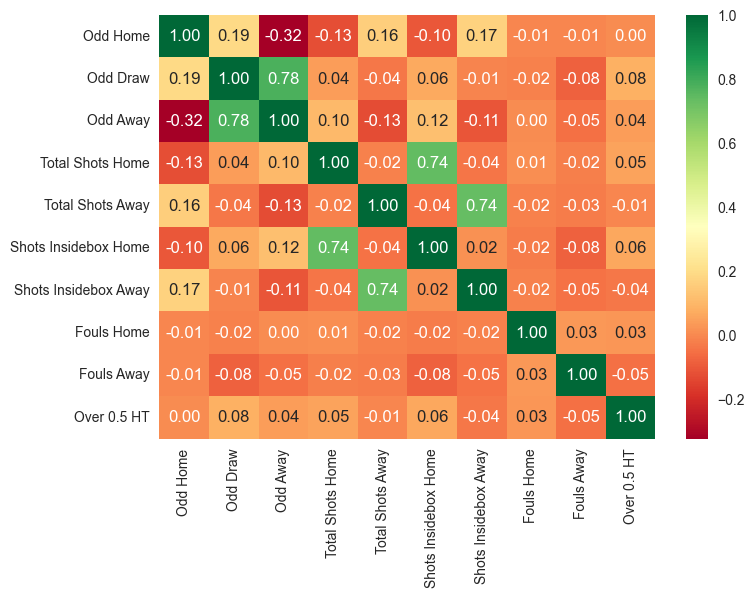

In [53]:
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdYlGn')

plt.show()

1    869
0    724
Name: Over 0.5 HT, dtype: int64


<Axes: ylabel='Over 0.5 HT'>

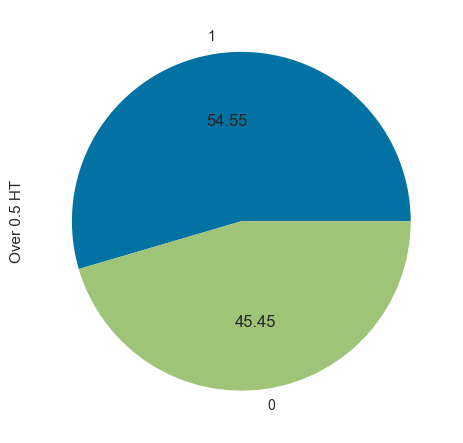

In [54]:
print(df['Over 0.5 HT'].value_counts())

df['Over 0.5 HT'].value_counts().plot.pie(autopct='%.2f')

<Axes: >

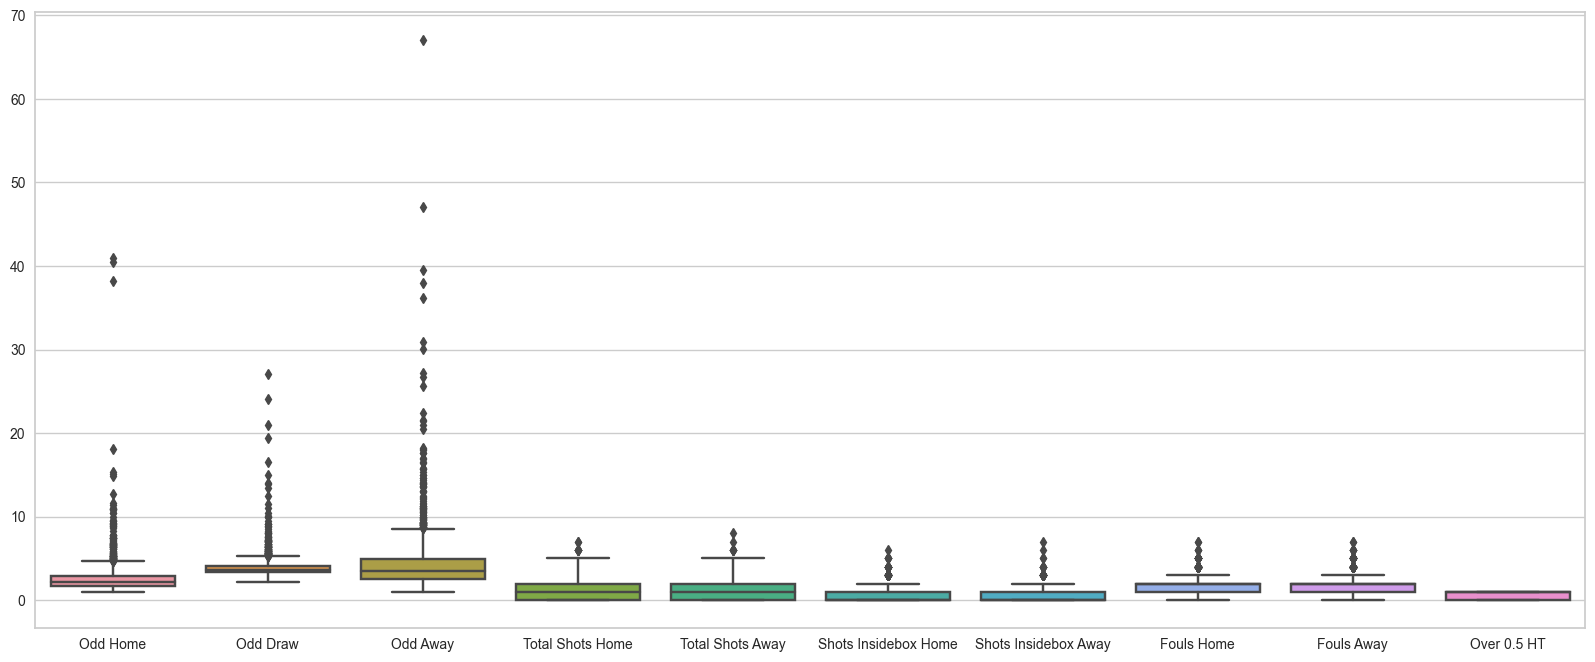

In [55]:
# Identificando Outliers

plt.figure(figsize=(20,8))

sns.boxplot(data=df)

In [56]:
def get_outliers_indexes(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1 # diferente de .quantile(0.5)

    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    indexes = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index

    print('{} -> {} outliers'.format(column, len(indexes)))

    return indexes

indexes = []

for column in df:
    new_outliers = get_outliers_indexes(column)

    indexes.extend(new_outliers)

indexes_without_duplicates = list(set(indexes))

print(len(indexes_without_duplicates))

df.drop(indexes_without_duplicates, inplace=True)

Odd Home -> 116 outliers
Odd Draw -> 121 outliers
Odd Away -> 104 outliers
Total Shots Home -> 10 outliers
Total Shots Away -> 8 outliers
Shots Insidebox Home -> 89 outliers
Shots Insidebox Away -> 53 outliers
Fouls Home -> 126 outliers
Fouls Away -> 153 outliers
Over 0.5 HT -> 0 outliers
560


<Axes: >

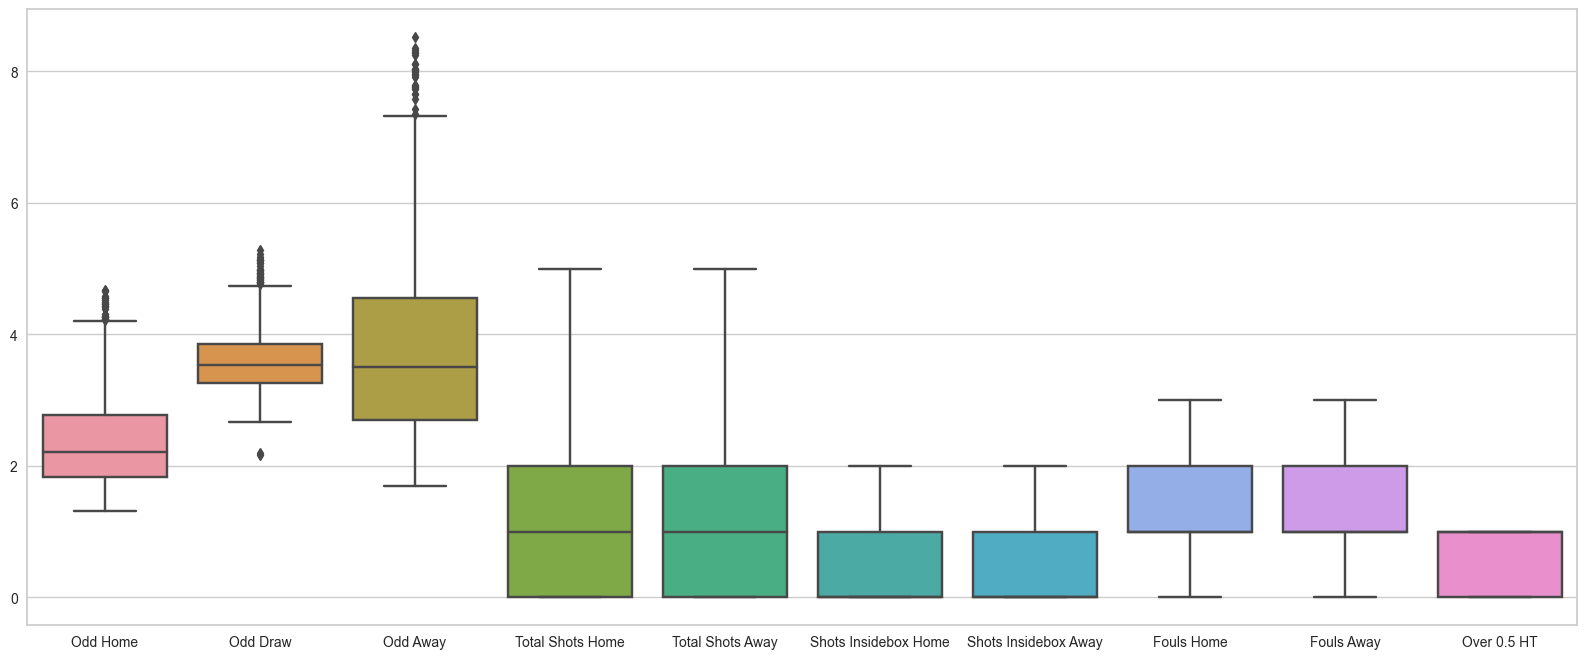

In [57]:
plt.figure(figsize=(20,8))

sns.boxplot(data=df)

In [58]:
X = df.loc[:, df.columns != 'Over 0.5 HT']
Y = df['Over 0.5 HT']

X, Y = RandomUnderSampler(random_state=42).fit_resample(X, Y)

df = X.copy()
df['Over 0.5 HT'] = Y

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

0    492
1    492
Name: Over 0.5 HT, dtype: int64


<Axes: ylabel='Over 0.5 HT'>

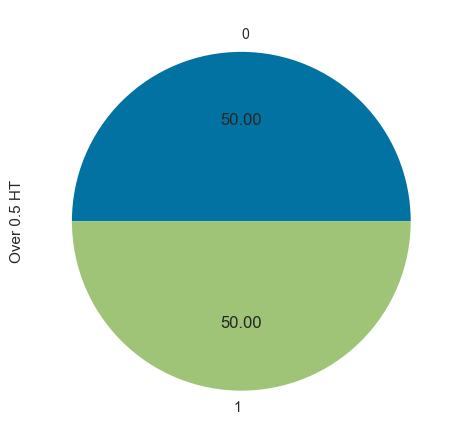

In [59]:
print(Y.value_counts())

Y.value_counts().plot.pie(autopct='%.2f')

In [60]:
random_state_scores = []

for state in np.arange(0, 100):
    model = GradientBoostingClassifier(learning_rate=0.45, subsample=0.5, n_estimators=64, max_depth=4, random_state=state)
    model.fit(x_train, y_train)
    random_state_scores.append(model.score(x_test, y_test))

best_random_state_score = np.argmax(random_state_scores)

In [61]:
model = GradientBoostingClassifier(learning_rate=0.45, subsample=0.5, n_estimators=64, max_depth=4, random_state=best_random_state_score)

model.fit(x_train, y_train)

prediction = model.predict(x_test)
prediction_proba = model.predict_proba(x_test)

joblib.dump(model, 'model.pkl')

['model.pkl']

In [62]:
roc_auc_score(y_test, prediction) 

0.5876712328767123

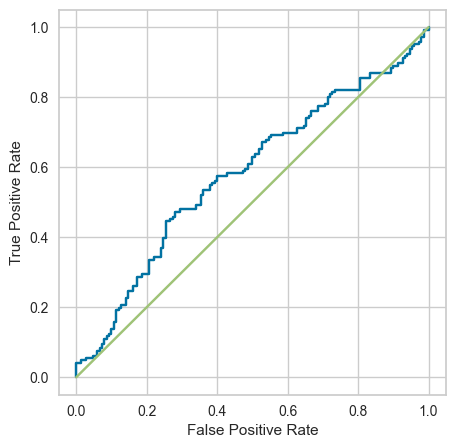

In [63]:
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
    
plot_sklearn_roc_curve(y_test, prediction_proba[:, 1])

In [64]:
classification_report(y_test, prediction, output_dict=True)

{'0': {'precision': 0.5921052631578947,
  'recall': 0.6,
  'f1-score': 0.596026490066225,
  'support': 150},
 '1': {'precision': 0.5833333333333334,
  'recall': 0.5753424657534246,
  'f1-score': 0.5793103448275863,
  'support': 146},
 'accuracy': 0.5878378378378378,
 'macro avg': {'precision': 0.5877192982456141,
  'recall': 0.5876712328767123,
  'f1-score': 0.5876684174469056,
  'support': 296},
 'weighted avg': {'precision': 0.5877785680417259,
  'recall': 0.5878378378378378,
  'f1-score': 0.5877813643741937,
  'support': 296}}

In [65]:
report_dict = {}

report_dict['accuracy 0'] = classification_report(y_test, prediction, output_dict=True)['0']['precision']
report_dict['accuracy 1'] = classification_report(y_test, prediction, output_dict=True)['1']['precision']

In [66]:
for key, value in report_dict.items():
    print('{}: {}'.format(key, round(value, 3)))

accuracy 0: 0.592
accuracy 1: 0.583


In [67]:
confusion_matrix(y_test, prediction)

array([[90, 60],
       [62, 84]], dtype=int64)

In [68]:
print('Odd para Under 0.5: {:.3f}'.format(1 / report_dict['accuracy 0']))
print('Odd para Over 0.5: {:.3f}'.format(1 / report_dict['accuracy 1']))

Odd para Under 0.5: 1.689
Odd para Over 0.5: 1.714


In [69]:
scaler = StandardScaler().fit_transform(df)

pca = PCA(n_components=2, random_state=42)

X = pca.fit_transform(scaler)

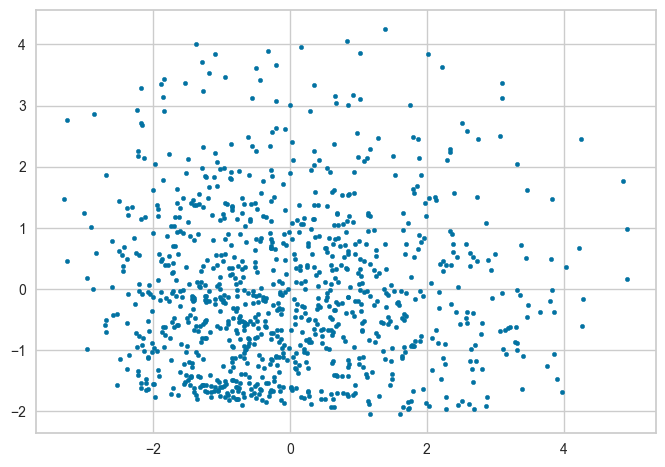

In [70]:
plt.scatter(
    X[:, 0], 
    X[:, 1], 
    s=10,
)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9, random_state=42),
                 k=(2, 10))

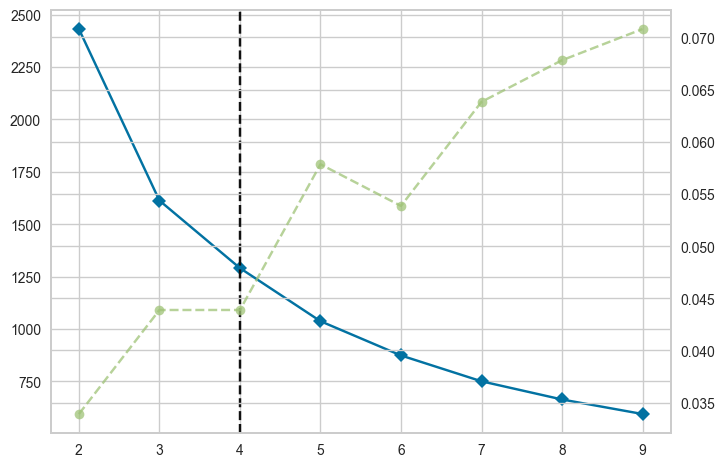

In [71]:
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(X)

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


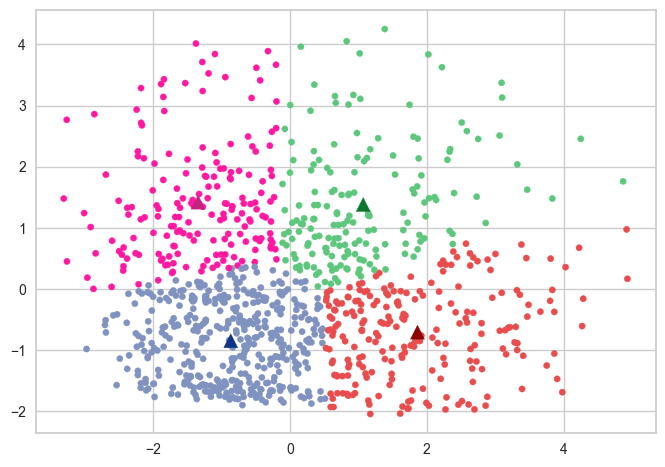

In [72]:
kmeans = KMeans(n_clusters=4, random_state=42)
prediction = kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_

centroid_x = [centroid[0] for centroid in centroids] # eixo x
centroid_y = [centroid[1] for centroid in centroids] # eixo y

cluster_color = {
    0: '#8092bf',
    1: '#5dc87d',
    2: '#e94c4c',
    3: '#ff18a0'
}

plt.scatter(
    [element[0] for element in X], 
    [element[1] for element in X], 
    c=list(map(lambda x: cluster_color[x], prediction)),
    s=20,
)
plt.scatter(centroid_x, centroid_y, marker='^', c=['#0f338a', '#0e772e', '#8e0000', '#c52181'], s=100)

In [73]:
df['Group'] = prediction

In [74]:
df.groupby('Group').mean()

,Odd Home,Odd Draw,Odd Away,Total Shots Home,Total Shots Away,Shots Insidebox Home,Shots Insidebox Away,Fouls Home,Fouls Away,Over 0.5 HT
Group,,,,,,,,,,
0,2.666724,3.384680,3.055690,0.721675,0.571429,0.197044,0.105911,1.463054,1.586207,0.492611
1,1.949653,3.760405,4.446012,2.144509,1.641618,1.248555,0.809249,1.485549,1.236994,0.450867
2,1.673018,4.099730,5.618784,1.292793,0.495495,0.536036,0.103604,1.500000,1.468468,0.594595
3,3.000492,3.376667,2.754481,1.114754,2.114754,0.562842,1.185792,1.420765,1.409836,0.448087


In [75]:
df['Group'].value_counts()

0    406
2    222
3    183
1    173
Name: Group, dtype: int64